# Problem Set 1 (20 + 40 + 30 = 90 points)

## Important information
1.  We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

2.  Please submit the single Jupyter Notebook file, where only Python and Markdown/$\LaTeX$ are used. Any hand-written solutions inserted by photos or in any other way **are prohibitive and will not be graded**. If you will have any questions about using Markdown, ask them!
3.  The works will be checked for **plagiarism**. The score will be divided by the number of similar works.

4. Some tasks in this assignment are bonus. It means that you can get maximum score for this assignment even if you ignore these tasks. However, if you get $y$ points for bonus tasks and $x$ points for regular tasks, then your score for the assignment will be $\min(90, x+y)$. If $x + y > 90$, then we will label your submission and take into account in the final grade releasing (e.g. in the border case).

## Problem 1. QR backpropagation (20 pts)

Our goal is to write an orthogonalization layer, that for an arbitrary rectangular matrix $A$ produces an orthonormal matrix $Q$ and (optionally) an upper triangualr matrix $R$ such that $A = QR$. 
In other words, we need to compute the QR decomposition.

There are problems when one need to optimize over orthogonal matrices, so using such layer can be a solution.

A standard algorithm to compute the QR decomposition is the Gram-Schmidt process.
For the linearly independent set of vectors $a_1,\dots,a_n$ (that are defined with the matrix $A$) it computes matrix $Q$ that contains orthonormalized set of vectors $q_1,\dots,q_n$.

This algorithm is listed below.

$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$

Obtained $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to make the system orthonormal you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.

We have $A = QR$. 
Matrix $Q$ consists of vectors $u_1, \dots, u_n$. 
Now let's look at the matrix $R$. 

$Q^*A = R$. 
So $R_{i, j} = (u_i, v_j)$ (assuming $u_i$ is already normalized). 
And it is exactly what we see in Gram-Schmidt algorithm:

$$ v_n = \frac{(v_n, u_1)}{(u_1, u_1)} u_1 + \frac{(v_n, u_2)}{(u_2, u_2)} u_2 + \dots + \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1} + u_n.$$ 

This is the representation of vectors $v_i$ in our newly computed ortonormal basis. 
Thus they form matrix $R$. 
These coefficients are in the upper triangular part of $R$, because when $i>j$ we get $R_{i j} = 0$, because then we get sum of scalar products of orthogonal vectors. 

There is a more [computationally stable version of the Gram-Schmidt algorithm](https://en.wikipedia.org/wiki/Gram–Schmidt_process#Numerical_stability) that reduces the loss of orthogonality in matrix $Q$. 
This algorithm is called the modified Gram-Schmidt algorithm.

The loop of orthogonalization is the same, except for the computing the vector $u_k$ simultaneously:

$$ u_n = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}
u_n$$

$$ 
 = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1},
$$

one need to iteratively update $u_k$ step-by-step for a better numerical stability.

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$


You are supposed to do the following tasks:

__1.__ (2 points) Implement the modified Gram-Schmidt algorithm in a function ```modified_gram_schmidt(A)``` using PyTorch.

__2.__ (1 point) Create a random matrix $A \in \mathbb{R}^{m \times n}$, $m \gg n$. For the arbitrary loss function, eg. $L(Q) = \sum_{i=0}^{m-1}\sum_{j=0}^{n-1} q_{ij}$, compute the gradient $\frac{\partial L}{\partial Q}$. Finally, compute $\frac{\partial L}{\partial A}$ using built-in PyTorch backpropagation through your implementation of QR decomposition (```modified_gram_schmidt(A)```).

__3.__ (2 points) Compute gradient $\frac{\partial L}{\partial A}$ using backpropagation through built-in PyTorch function for computing QR decomposition.

In [ ]:
# install dependencies
!pip install memory-profiler
import torch


def modified_gram_schmidt(A):
    """
    Computes QR decomposition of matrix A
    
    Input: 
        A - n x m matrix
    Output:
        Q - n x m orthonormal matrix
        R - m x m upper triangular matrix
    """
    
    # Your code here
    n, m = A.shape

    Q = torch.clone(A)

    for i in range(m):
        vec_i = torch.zeros((1, m)) #vector  to i-th column in matrix
        vec_i[0, i] = 1
        for j in range(i):
            pos_i, pos_j = torch.zeros(m), torch.zeros(m) #i-th and j-th column of matrix
            pos_j[j] = 1
            pos_i[i] = 1
            Q -= ((Q @ pos_i) @ (Q @ pos_j)) / ((Q @ pos_j) @ (Q @ pos_j)) * (Q @ pos_j)[..., None] @ vec_i

    Q = Q / torch.linalg.norm(Q, dim=0)

    R = Q.T @ A

    return Q, R


m = 100
n = 20
A = torch.rand((m, n), requires_grad=True)

# Your code is below
Q1, R1 = torch.linalg.qr(A) # torch version
Q2, R2 = modified_gram_schmidt(A) # modified_gram_schmidt

print('Sanity check:')
print(f'||A - QR||={torch.norm(A - Q2 @ R2)}')
print(f'||I - Q^TQ||={torch.norm(torch.eye(Q2.shape[-1]) - Q2.T @ Q2)}')

loss1 = Q1.sum()
loss2 = Q2.sum()

# TODO compute gradients
loss1.backward()
grad_1 = A.grad
A.grad.zero_()
loss2.backward()
grad_2 = A.grad


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Sanity check:
||A - QR||=9.574690920999274e-06
||I - Q^TQ||=1.429650637874147e-06


In [ ]:
print(grad_1)
print(grad_2)

tensor([[-0.3807, -0.3771, -0.2113,  ..., -0.0274, -0.0292, -0.0293],
        [-0.3159, -0.1918, -0.0557,  ...,  0.0331,  0.0404,  0.0424],
        [-0.2376, -0.2665, -0.1276,  ...,  0.0592,  0.0686,  0.0706],
        ...,
        [-0.3146, -0.2105, -0.1008,  ..., -0.0202, -0.0225, -0.0228],
        [ 0.1024,  0.1118,  0.0535,  ...,  0.0191,  0.0183,  0.0180],
        [-0.1242, -0.0937, -0.0480,  ..., -0.0038, -0.0052, -0.0061]])
tensor([[-0.3807, -0.3771, -0.2113,  ..., -0.0274, -0.0292, -0.0293],
        [-0.3159, -0.1918, -0.0557,  ...,  0.0331,  0.0404,  0.0424],
        [-0.2376, -0.2665, -0.1276,  ...,  0.0592,  0.0686,  0.0706],
        ...,
        [-0.3146, -0.2105, -0.1008,  ..., -0.0202, -0.0225, -0.0228],
        [ 0.1024,  0.1118,  0.0535,  ...,  0.0191,  0.0183,  0.0180],
        [-0.1242, -0.0937, -0.0480,  ..., -0.0038, -0.0052, -0.0061]])


__4.__ (13 points total) Write the backpropagation $\frac{\partial L}{\partial A}$ from scratch with PyTorch. Do not forget to use ```requires_grad=False``` to disable PyTorch autograd accumulation of the gradient.

  a) (2 points) Derive analytically the gradient $\frac{\partial y}{\partial x}$ of vector normalization operation $y := x/\|x\|$.

  b) (1 point) Implement backward through the vector normalization operation (can be implemented either in the function ```backward_normalization``` or further inside the code).

  c) (2 points) Derive analytically the gradient $\frac{\partial u_k}{\partial v_j}$ of the othonormalization operation:

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$

  d) (2 points) Implement backward through the othonormalization operation (can be implemented either in the function ```backward_orthogonalization``` or further inside the code).

  e) (1 point) Implement the QR forward pass (almost identically to ```modified_gram_schmidt```, but with storing the additional data nesessary for backpropagation) with the method ```forward``` of class ```QR``` (see template below).

  f) (5 points) Implement the QR backward pass using previously implemented functions and place it in the method ```backward``` of class ```QR```  (see template below).

__5.__ (2 points) Look at obtained $Q$ and $R$ matrices for each approach (steps 2, 3, 4), verify that $A \approx QR$ and $Q^TQ \approx I$. Measure the required memory for backpropagation (eg. with ```memory_profiler```). 
Compare the results of three approaches: 

- gradient from the PyTorch built-in function
- gradient from PyTorch autograd applied to your function ```modified_gram_schmidt```
- your custom implementation of backward step from analytical expressions. 

Compare the theoretical asymptotics of the memory usage for the backpropagation of the modified Gram-Schmidt algorithm with every approach listed above. 
What data is needed for backpropagation and thus affects the memory consumption?

### Your solution
* a)
$$ \frac{\partial y_i}{\partial x_j} = \frac{\partial}{\partial x_j} \frac{x_i}{\|x\|} = \frac{\delta_{ij}}{\|x\|} - \frac{x_i}{\|x\|^2} \frac{\partial \|x\|}{\partial x_j} = \frac{\delta_{ij}}{\|x\|} - \frac{x_i}{\|x\|^2} \frac{x_j}{\|x\|} = \frac{\|x\|^2 \delta_{ij} - x_ix_j}{\|x\|^3}$$
$$ \frac{\partial y}{\partial x} = \frac{1}{\|x\|^3} \left(\|x\|^2 I - xx^T \right)$$
* c) <br>
From theoretical point of view modified and regular Gram-Schmidt algorithm are the same, so we can compute gradients for the regular one:
$$
\frac{\partial u_k}{\partial v_j} = 0, \quad j > k
$$
$$
\frac{\partial u_k}{\partial v_k} =\frac{\partial}{\partial v_k}\left( v_k-\sum_{i=1}^{k-1}\frac{(v_k, u_i)}{(u_i, u_i)}u_i \right) = I - \sum_{i=1}^{k-1}\frac{u_iu_i^T}{(u_i, u_i)}, \quad j = k
$$

When $j < k$:

$$
\frac{\partial u_k}{\partial v_j} = \frac{\partial}{\partial v_j}\left( v_k-\sum_{i=1}^{k-1}\frac{(v_k, u_i)}{(u_i, u_i)}u_i \right) = 
-\sum_{i=1}^{k-1}\frac{\partial}{\partial v_j} \left[\frac{(v_k, u_i)}{(u_i, u_i)}u_i \right]
$$

$$
\frac{\partial}{\partial v_j} \left[\frac{(v_k, u_i)}{(u_i, u_i)}u_i \right] =\frac{(v_k, u_i)}{(u_i, u_i)}\frac{\partial u_i}{\partial v_j} + \frac{u_iv_k^T}{(u_i, u_i)}\frac{\partial u_i}{\partial v_j} - \frac{(v_k, u_i)}{(u_i, u_i)^2}2u_iu_i^T\frac{\partial u_i}{\partial v_j} =
\left(\frac{u_iv_k^T}{(u_i, u_i)} + \frac{(v_k, u_i)}{(u_i, u_i)}I - \frac{2(v_k, u_i)}{(u_i, u_i)^2}u_iu_i^T\right)\frac{\partial u_i}{\partial v_j}
$$

$$
\frac{\partial u_k}{\partial v_j} = -\sum_{i=1}^{k-1}\frac{1}{(u_i, u_i)} \left(u_iv_k^T + (v_k, u_i)I - \frac{2(v_k, u_i)}{(u_i, u_i)}u_iu_i^T\right)\frac{\partial u_i}{\partial v_j}, \quad j < k
$$


In [ ]:
def backward_normalization(x):
    res =  (torch.eye(x.shape[0]) * (torch.linalg.norm(x) ** 2) - (x.reshape((-1, 1)) @ x.reshape((1, -1))))
    return res / (torch.linalg.norm(x) ** 3)


def backward_orthogonalization(Q, A):
    # Your code
    derivatives = {}
    for j in range(A.shape[1]):
        for k in range(j, A.shape[1]):
            if j == k:
                sum_term = sum([Q[:, i].reshape((-1, 1)) @ Q[:, i].reshape((1, -1)) / torch.linalg.norm(Q[:, i]) ** 2 for i in range(k)])
                derivatives[(k, j)] = torch.eye(Q.shape[0]) - sum_term
            else:
                result = torch.zeros((Q.shape[0], Q.shape[0]))
                for i in range(j, k):
                    result -= (1 / torch.linalg.norm(Q[:, i]) ** 2) * \
                        (Q[:, i].reshape((-1, 1)) @ A[:, k].reshape((1, -1)) + \
                         A[:, k] @ Q[:, i] * torch.eye(Q.shape[0]) - \
                            (2.0 * A[:, k] @ Q[:, i] / torch.linalg.norm(Q[:, i]) ** 2) \
                                      * (Q[:, i].reshape((-1, 1)) @ Q[:, i].reshape((1, -1)))) @ derivatives[(i, j)]
                derivatives[(k, j)] = result
    return derivatives

class QR():
    def forward(self, A):
        """
        Computes QR decomposition of matrix A

        Input: 
            A - n x m matrix
        Output:
            Q - n x m orthonormal matrix
            R - m x m upper triangular matrix
        """

        # Your code
        n, m = A.shape

        Q = torch.clone(A)

        for i in range(m):
            vec_i = torch.zeros((1, m)) #vector  to i-th column in matrix
            vec_i[0, i] = 1
            for j in range(i):
                pos_i, pos_j = torch.zeros(m), torch.zeros(m) #i-th and j-th column of matrix
                pos_j[j] = 1
                pos_i[i] = 1
                Q -= ((Q @ pos_i) @ (Q @ pos_j)) / ((Q @ pos_j) @ (Q @ pos_j)) * (Q @ pos_j)[..., None] @ vec_i
        
        self.Q_unnorm = Q
        Q = Q / torch.linalg.norm(Q, dim=0)

        R = Q.T @ A

        self.Q = Q
        self.A = A
        self.orthogonal_derivatives = backward_orthogonalization(self.Q_unnorm, self.A)  

        return Q, R
        

    def backward(self, grad_output):
        """
        Computes QR decomposition of matrix A

        Input: 
            grad_output - n x m matrix, derivative of the previous layer (derivative of loss dL/dQ  in our case)
        Output:
            grad_input - n x m derivative dL/dA
        """
        # Your code
        grad_input = torch.zeros_like(self.A)
        for j in range(self.A.shape[1]):
            for k in range(j, self.A.shape[1]):
                grad_input[:, j] += grad_output[:, j] @ backward_normalization(self.Q_unnorm[:, k]) @ self.orthogonal_derivatives[(k, j)]
         
        return grad_input

In [ ]:
qr = QR()
A = torch.rand((m, n))

Q, R = qr.forward(A)
loss1 = Q.sum()

# TODO compute losses and do backpropagation
# compute dL / dQ and finally dL / dA
dL_dQ = torch.ones_like(Q)
dL_dA = qr.backward(dL_dQ)


A_autograd = A.clone().detach().requires_grad_(True)
Q_autograd, R_autograd = qr.forward(A_autograd)
loss2 = Q_autograd.sum()
loss2.backward()
print('Difference between gradients:', float(torch.linalg.norm(dL_dA - A_autograd.grad)))

Difference between gradients: 5.794282969873166e-06


In [ ]:
%load_ext memory_profiler

In [ ]:
%%file compare_all.py
import torch


def backward_normalization(x):
    res =  (torch.eye(x.shape[0]) * (torch.linalg.norm(x) ** 2) - (x.reshape((-1, 1)) @ x.reshape((1, -1))))
    return res / (torch.linalg.norm(x) ** 3)


def backward_orthogonalization(Q, A):
    # Your code
    derivatives = {}
    for j in range(A.shape[1]):
        for k in range(j, A.shape[1]):
            if j == k:
                sum_term = sum([Q[:, i].reshape((-1, 1)) @ Q[:, i].reshape((1, -1)) / torch.linalg.norm(Q[:, i]) ** 2 for i in range(k)])
                derivatives[(k, j)] = torch.eye(Q.shape[0]) - sum_term
            else:
                result = torch.zeros((Q.shape[0], Q.shape[0]))
                for i in range(j, k):
                    result -= (1 / torch.linalg.norm(Q[:, i]) ** 2) * \
                        (Q[:, i].reshape((-1, 1)) @ A[:, k].reshape((1, -1)) + \
                         A[:, k] @ Q[:, i] * torch.eye(Q.shape[0]) - \
                            (2.0 * A[:, k] @ Q[:, i] / torch.linalg.norm(Q[:, i]) ** 2) \
                                      * (Q[:, i].reshape((-1, 1)) @ Q[:, i].reshape((1, -1)))) @ derivatives[(i, j)]
                derivatives[(k, j)] = result
    return derivatives


class QR():
    def forward(self, A):
        """
        Computes QR decomposition of matrix A

        Input: 
            A - n x m matrix
        Output:
            Q - n x m orthonormal matrix
            R - m x m upper triangular matrix
        """

        # Your code
        n, m = A.shape

        Q = torch.clone(A)

        for i in range(m):
            vec_i = torch.zeros((1, m)) #vector  to i-th column in matrix
            vec_i[0, i] = 1
            for j in range(i):
                pos_i, pos_j = torch.zeros(m), torch.zeros(m) #i-th and j-th column of matrix
                pos_j[j] = 1
                pos_i[i] = 1
                Q -= ((Q @ pos_i) @ (Q @ pos_j)) / ((Q @ pos_j) @ (Q @ pos_j)) * (Q @ pos_j)[..., None] @ vec_i
        
        self.Q_unnorm = Q
        Q = Q / torch.linalg.norm(Q, dim=0)

        R = Q.T @ A

        self.Q = Q
        self.A = A
        self.orthogonal_derivatives = backward_orthogonalization(self.Q_unnorm, self.A)  

        return Q, R
        

    def backward(self, grad_output):
        """
        Computes QR decomposition of matrix A

        Input: 
            grad_output - n x m matrix, derivative of the previous layer (derivative of loss dL/dQ  in our case)
        Output:
            grad_input - n x m derivative dL/dA
        """
        # Your code
        grad_input = torch.zeros_like(self.A)
        for j in range(self.A.shape[1]):
            for k in range(j, self.A.shape[1]):
                grad_input[:, j] += grad_output[:, j] @ backward_normalization(self.Q_unnorm[:, k]) @ self.orthogonal_derivatives[(k, j)]
         
        return grad_input

        
def modified_gram_schmidt(A):
    """
    Computes QR decomposition of matrix A
    
    Input: 
        A - n x m matrix
    Output:
        Q - n x m orthonormal matrix
        R - m x m upper triangular matrix
    """
    
    # Your code here
    n, m = A.shape

    Q = torch.clone(A)

    for i in range(m):
        vec_i = torch.zeros((1, m)) #vector  to i-th column in matrix
        vec_i[0, i] = 1
        for j in range(i):
            pos_i, pos_j = torch.zeros(m), torch.zeros(m) #i-th and j-th column of matrix
            pos_j[j] = 1
            pos_i[i] = 1
            Q -= ((Q @ pos_i) @ (Q @ pos_j)) / ((Q @ pos_j) @ (Q @ pos_j)) * (Q @ pos_j)[..., None] @ vec_i

    Q = Q / torch.linalg.norm(Q, dim=0)

    R = Q.T @ A

    return Q, R

    
def full_torch(A):
    Q, R = torch.linalg.qr(A) # torch version
    loss = Q.sum()
    loss.backward()
    return A.grad


def modified_gram_schmidt_autograd(A):
    Q, R = modified_gram_schmidt(A) # torch version
    loss = Q.sum()
    loss.backward()
    return A.grad


def custom(A):
    qr = QR()

    Q, R = qr.forward(A)
    loss1 = Q.sum()

    dL_dQ = torch.ones_like(Q)
    return qr.backward(dL_dQ)
    

Writing compare_all.py


In [ ]:
from compare_all import *
A = torch.rand((m, n), requires_grad=True)

%mprun -f full_torch full_torch(A)

Filename: /Users/marknuzhnov/Desktop/Study/Skoltech/Term 4/DL/compare_all.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   115     51.5 MiB     51.5 MiB           1   def full_torch(A):
   116     51.8 MiB      0.3 MiB           1       Q, R = torch.linalg.qr(A) # torch version
   117     51.8 MiB      0.0 MiB           1       loss = Q.sum()
   118     52.3 MiB      0.5 MiB           1       loss.backward()
   119     52.3 MiB      0.0 MiB           1       return A.grad

In [ ]:
%mprun -f modified_gram_schmidt_autograd modified_gram_schmidt_autograd(A)

Filename: /Users/marknuzhnov/Desktop/Study/Skoltech/Term 4/DL/compare_all.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   122     43.9 MiB     43.9 MiB           1   def modified_gram_schmidt_autograd(A):
   123     52.7 MiB      8.8 MiB           1       Q, R = modified_gram_schmidt(A) # torch version
   124     52.8 MiB      0.1 MiB           1       loss = Q.sum()
   125     54.2 MiB      1.4 MiB           1       loss.backward()
   126     54.2 MiB      0.0 MiB           1       return A.grad

In [ ]:
%mprun -f custom custom(A)

Filename: /Users/marknuzhnov/Desktop/Study/Skoltech/Term 4/DL/compare_all.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   129     52.4 MiB     52.4 MiB           1   def custom(A):
   130     52.4 MiB      0.0 MiB           1       qr = QR()
   131                                         
   132    234.3 MiB    181.9 MiB           1       Q, R = qr.forward(A)
   133    234.5 MiB      0.2 MiB           1       loss1 = Q.sum()
   134                                         
   135    234.6 MiB      0.1 MiB           1       dL_dQ = torch.ones_like(Q)
   136    247.3 MiB     12.7 MiB           1       return qr.backward(dL_dQ)

### Bonus tasks

__6.__ (10 points) Modify the previous code to be memory-efficient. 

Hint: not all intermediate variables need to be stored for backpropagation.

__7.__ (3 points) Again, measure the required memory for backpropagation. Explain the theoretical asymptotics of the memory usage for the memory-efficient backpropagation.


## Problem 2. Voice classification (40 pts)

In this assigment you will have a chance to develop a voice-anti-spoofing algorithm, enhancing your skills in standard PyTorch classificaton development pipeline.

There are several types of attack: 
- replay attacks, when one records and repeats someone's voice, 
- impresario attacks, when the speaker mimics the target's voice like an actor and 
- the most interesting are deepfake attack, based on text-to-speech, voice cloning and voice conversion algorithms. 

In this work we will focus on deepfake attack and try to differ them from genuine (or bona-fide) speech.

We will use data, provided by organisers of biannual [ASVspoof](https://www.asvspoof.org/) contest. More precisely, we will take subpart `ASVspoof_2019LA` dataset, which consist of 17 different attacks DF attack types and bona-fide. All recordings were augmented to be close to real telephone recordings. We will not take 2021 data, but if you want, you can use 2021 data as test and 2019 data as train and validation.

The initital dataset can be downloaded from [here](https://datashare.ed.ac.uk/handle/10283/3336). However, we [provide you smaller subsample](https://drive.google.com/drive/folders/1-CyCFA3komqrtyoYj21y5gzfh_vcKBYx?usp=share_link) of dev (val) and eval (test) parts to make work in colab relatively possible :) . You can download it locally or put into you Drive. You will need around 3GB free space, think about creating a new account if you don't have enough.

We encourage you to look through data [overview](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_evaluation_plan.pdf?sequence=1&isAllowed=y) and result summary [paper](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_Interspeech2019_submission.pdf?sequence=2&isAllowed=y).

One important thing to notice: main application of this algorithms is in voice-biometry, when we want to stop illegal intruder. Thus, there are two (or 3) common ways of developing VAS algorithms: speaker-aware, we we train verification model which is sensitive to spoofing and differs bona-fide and impostor or we combinde verification score and score of VAS model to decide, whetherr the person is the same, and finally simple and general countermeasures setup, when given audio and model should predict whether it is a spoof or bona-fide. We will work on the last setup.

**Important: feel free not to use pre-defined functions, you can solve the task as you wish or change functions/pipelines significantly.** 

#### Preparations
It is a good practice to log and check you experiments. In this assignemnt, we ask you to sign up in wandb, log your experiments and give us a link to your project and attach plots/report in the notebook with your solution.

In [2]:
!pip install wandb
import copy
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from typing import Optional
import torch
import torch.nn as nn
import torchaudio
# import librosa
import sklearn.metrics as metrics
import wandb
from torchvision.models import resnet50, resnet18, efficientnet_b0
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=de37a3e2614320510bfdeacee70038fc90befc9cfa60ecee8dfe143512760e1b
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [3]:
# https://wandb.ai/quickstart

!wandb login 7ed66683ab734c5607259a94b5937616a911f67b

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
#wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["SmallModel", "LA"]) init later
SEED = 42  # do not change it
# mount drive if you wish

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Mounted at /content/drive/
/content/drive/MyDrive


In [6]:
!tar -xvf "/content/drive/MyDrive/for_collab.tar" -C "/content/drive/MyDrive/"

Streaming output truncated to the last 5000 lines.
for_collab/train_flac/LA_T_1617644.flac
for_collab/train_flac/LA_T_1716558.flac
for_collab/train_flac/LA_T_1971994.flac
for_collab/train_flac/LA_T_4182747.flac
for_collab/train_flac/LA_T_3050892.flac
for_collab/train_flac/LA_T_2884364.flac
for_collab/train_flac/LA_T_8914964.flac
for_collab/train_flac/LA_T_9052723.flac
for_collab/train_flac/LA_T_2797155.flac
for_collab/train_flac/LA_T_3322290.flac
for_collab/train_flac/LA_T_8111732.flac
for_collab/train_flac/LA_T_8367117.flac
for_collab/train_flac/LA_T_7567233.flac
for_collab/train_flac/LA_T_1633985.flac
for_collab/train_flac/LA_T_3291562.flac
for_collab/train_flac/LA_T_8416101.flac
for_collab/train_flac/LA_T_6434382.flac
for_collab/train_flac/LA_T_3822266.flac
for_collab/train_flac/LA_T_1866115.flac
for_collab/train_flac/LA_T_8461627.flac
for_collab/train_flac/LA_T_1584771.flac
for_collab/train_flac/LA_T_3186083.flac
for_collab/train_flac/LA_T_9331964.flac
for_collab/train_flac/LA_T_88

In [7]:
# to make dataframes
path_la_train = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
path_la_dev = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
path_la_eval = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

flac_la_train = "for_collab/train_flac/"
flac_la_dev = "for_collab/flac_dev/"
flac_la_eval = "for_collab/flac_eval/"

In [8]:
columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
df = pd.read_csv(path_la_train, sep=" ", header=None)
df.columns = columns
df.head()

,speaker_id,audio_file_name,system_id,skip,class
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [9]:
def makedf_ultimate(txt_file_path, flac_path, dataset_name='ASVspoof', data_type='LA', year=2019):
    
    if dataset_name=='ASVspoof':
        name = dataset_name+str(year)+data_type
        if data_type=='DF':
            attack_name = 'deepfake'
        elif data_type=='LA':
            attack_name = 'deepfake'
        else:
            attack_name = 'replay'
            
        df = pd.read_csv(txt_file_path, sep=" ", header=None)

            
        if year == 2019:
            df.columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
            df['dataset'] = name
            di = {'bonafide':0, 'spoof':1} # assign classes

            df['class'] = df['class'].map(di)
            # m = df['class'] == 0
            # df.loc[m, 'attack'] = 'noattack'
            df['audio_path'] = flac_path + df['audio_file_name'] + '.flac'
            df = df[["speaker_id", "audio_path", "class"]]
        
    # df = df[['audio_path', 'class', 'dataset', 'attack']]
    df = df[["speaker_id", "audio_path", "class"]]
    df = df.reset_index(drop=True)
    return df

In [10]:
df_train = makedf_ultimate(path_la_train, flac_la_train, year=2019, data_type='LA')
df_dev = makedf_ultimate(path_la_dev, flac_la_dev, year=2019, data_type='LA')
df_eval = makedf_ultimate(path_la_eval, flac_la_eval, year=2019, data_type='LA')

In [11]:
new_df = [] # Leave only existing instances
for ds, path_1, path_2 in zip([df_train, df_dev, df_eval], [flac_la_train, flac_la_dev, flac_la_eval], ['train_flac/', 'flac_dev/', 'flac_eval/']):
  q = os.listdir(path_1)
  q = ['for_collab/' + path_2 + j.split(".")[0] + '.flac' for j in q]
  new_df += [ds[ds["audio_path"].isin(q)]]

In [12]:
df_train, df_dev, df_eval = new_df[0], new_df[1], new_df[-1]

**Task 1.1 (2 points)** Check data distribution. Is it imbalanced? How are you going to deal with it?

Hints: upsampling, downsampling, add new data, e.g. from this [source](https://commonvoice.mozilla.org/) (but will new audios have the same distribution?), or adjust loss functions.

**Answer**
Train data is imbalanced.
For now we will drop some observations to make it balanced.

In [13]:
# for dev and eval, let's simplify the task and use smaller amount of data, but balanced to better understand metrics
# we need this functions, because it removes unuploaded data from our dataframes
def balanced_split(df):
    k = min(len(df[df['class']==0]), len(df[df['class']==1]))
    print(k)
    df_bf = df[df['class']==0].sample(frac=1, random_state=SEED).iloc[0:k]
    df_spoof = df[df['class']==1].sample(frac=1, random_state=SEED).iloc[0:k]

    df_bf = df_bf.append([df_spoof], ignore_index=True)
    df_bf = df_bf.reset_index(drop=True)
    print(f'Dropped {df.shape[0] - df_bf.shape[0]} observations')
    return df_bf


df_train = balanced_split(df_train)
df_eval = balanced_split(df_eval)
df_dev = balanced_split(df_dev)

2580
Dropped 20220 observations
7355
Dropped 0 observations
2548
Dropped 0 observations


<ipython-input-13-ccc328f595d0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bf = df_bf.append([df_spoof], ignore_index=True)


In [14]:
# for audio manipulations we advise you to use torchaudio or librosa
x, sr = torchaudio.load(df_eval["audio_path"].iloc[0])

In [ ]:
ipd.display(ipd.Audio(x, rate=sr))

**Task 1.2. (1 point)** Display several spoof and bona-fide audios. Can you hear the difference?

In [ ]:
for i in range(2):
  print('Spoof')
  x, sr = torchaudio.load(df_eval[df_eval['class'] == 0]["audio_path"].iloc[i])
  ipd.display(ipd.Audio(x, rate=sr))
  print('Bona-fide')
  x, sr = torchaudio.load(df_eval[df_eval['class'] == 1]["audio_path"].iloc[i])
  ipd.display(ipd.Audio(x, rate=sr))

Spoof


Bona-fide


Spoof


Bona-fide


### Custom dataset and Model

You can find inspiration and hints in 
- https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://pypi.org/project/audiomentations/ 
- https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html
- and any other blogposts about spectrograms

**Task 2.1 (5 points)** We can work with audios as with images, transforming into spectrograms. Here your task is to implement simple model, which receives raw wav (amplitudes, but probably already preprocced in dataset), transforms it into mel-spectrogram, changes amplitude to DB scale (if you want) and then procceses through the layers. You are free to use ready pre-trained backbones, e.g. from `torchvision.models` and fine-tune them. However, if you want to practise more, create something on your own. Large models with `requires_grad=True` for all parameters will probably result in problems on training in colab. 

In [15]:
class WavResNet(nn.Module):
    def __init__(self, classes=None, resample=16000, n_mels=80, melspec_config=None):
        super().__init__()
        n_fft = 1024
        win_length = None
        hop_length = 512

        # Define transform
        self.spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
        )        
        model = efficientnet_b0(weights='DEFAULT')
        model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
        model.classifier[-1] = nn.Linear(1280, 1, bias=True)
        self.network = model
        # or create your own layers and use them in forward pass


    def forward(self, x, wav_lens: Optional[torch.Tensor]=None):  # can check the length if you want. this is helpful for inference

        spectrogram = self.spectrogram(x)
        out = torch.sigmoid(self.network(spectrogram))
        return out

**Task 2.2 (1 point)**
In your opinion, which approach is better for binary classification: 
- Model's last layer output has shape 1, train with BCE-like loss.
- Model's last layer output has shape 2, train with cross-entropy like loss. 

**Task 2.3 (3 points)** Create custom dataset, which recieves ```df``` and returns preprocessed audio.

**Task 2.4 (1 point)** Should we use augmentaions? If yes, which ones? 

Sigmoid is a special case of Softmax:
$$ \frac{1}{1 + e^{-x}} = \frac{e^x}{1 + e^x} = \frac{e^x}{e^0 + e^x}$$
It is basically the case of 2 output neurons, but one of them always outputs 0. <br>
It is better to use 1-output layer because it will be updated faster.

In [16]:
class DatasetWav(Dataset):

    def __init__(self, data_frame, padding_sec=4, default_sr=16000, transform=None):
        self.df = data_frame
        self.padding_sec = padding_sec
        self.default_sr = default_sr
        self.labels = data_frame['class']
        self.paths = data_frame['audio_path']
        self.vad = torchaudio.functional.vad # in this task you are free to ommit it in order to speed up calculations,
                                            # also the provided data should be rather clean
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        label = self.labels.iloc[idx]
        path = self.paths.iloc[idx]
        if label == None or path == None:
          print(label, path)
        waveform, sr = torchaudio.load(path) # normalize=True
        # transform waveform from stereo to mono channel 
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.default_sr) # should we use it for our data or can ommit? 
        # waveform = resample_transform(waveform)
        # waveform = self.vad(waveform, sr)

        # came up with idea, what to do if audio is longer or shorter than reuqired
        if (waveform.shape[1] < self.padding_sec * self.default_sr):
          wf = torch.clone(waveform)
          n = self.padding_sec * self.default_sr // waveform.shape[1]
          for _ in range(n): 
            waveform = torch.cat((waveform, wf), 1)
          waveform = waveform[:, :self.padding_sec * self.default_sr]
        else:
          waveform = waveform[:, :self.padding_sec * self.default_sr]

        
        return waveform, label

In [17]:
# check that works
batch_size = 3
train_dataset_wavs = DatasetWav(df_train)
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
x, y = next(iter(train_dataloader_wavs))
model = WavResNet(classes=2, resample=16000, n_mels=80, melspec_config=None)
model(x)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 28.4MB/s]


tensor([[0.4946],
        [0.5165],
        [0.5293]], grad_fn=<SigmoidBackward0>)

### Train and Test functions
**Task 3.0 (1 point)** What is the difference between `model.train()` and `model.eval()`? Does `model.eval()` mode take gradient statisitcs into account?

**Task 3.1 (5 points)** Implement train and test functions, which iterate over all batches. Do logging of loss, accuracy on each batch and after every epoch. Check equal error rate EER, explain, what is it.

**3.0** <br>
model.eval() fixes BatchNorms and disables Dropouts. 

In [18]:
def calculate_eer(y, y_score):
  fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)
  return eer, thresh

In [19]:
def train(model, dataloaders, criterion, optimizer, 
          num_epochs=3, scheduler=None, savename=None,
          print_counter=10, decay_factor=10,
          device=torch.device("cuda")):
    
    
    for epoch in range(num_epochs):
      train_acc, train_loss = 0, 0
      model.train()
      for step, (spectrograms, labels) in enumerate(dataloaders['train']):
        optimizer.zero_grad()
        spectrograms = spectrograms.to(device)
        preds = model(spectrograms).squeeze().cpu()
        loss = criterion(preds, labels.float())
        preds = preds > 0.5
        train_loss += loss * labels.size(0)
        train_acc += torch.sum(preds == labels)
        wandb.log({'train_batch_loss':loss, 'train_batch_acc':torch.sum(preds == labels) / len(labels)})
        # accuracy, thresh = calculate_eer(labels.detach().cpu().numpy(), m(prediction).detach().cpu().numpy()[:, 1])
        loss.backward()
        optimizer.step()
        if (step + 1) % print_counter == 0:
          print(f'epoch: {epoch}, step: {step + 1}, train_loss: {loss}, batch_acc: {torch.sum(preds == labels) / len(labels)}')

      
      train_loss = train_loss / len(dataloaders['train'].dataset)
      train_acc = train_acc / len(dataloaders['train'].dataset)  
      print(f'\nepoch: {epoch}, train_loss: {train_loss}, train_acc: {train_acc}\n')
      
      print('Train finished')

      model.eval()
      with torch.no_grad():
        val_loss = 0.
        val_acc = 0
        for step, (spectrograms, labels) in enumerate(dataloaders['val']):
          spectrograms = spectrograms.to(device)
          preds = model(spectrograms).squeeze().cpu()
          loss = criterion(preds, labels.float())
          val_loss += loss * labels.size(0)
          preds = preds > 0.5
          val_acc += torch.sum(preds == labels)

          wandb.log({'val_batch_loss':loss, 'val_batch_acc':torch.sum(preds == labels) / len(labels)})

          if (step + 1) % print_counter == 0:
            print(f'epoch: {epoch}, step: {step + 1}, val_loss: {loss}, batch_acc: {torch.sum(preds == labels) / len(labels)}')


        val_loss = val_loss / len(dataloaders['val'].dataset)
        val_acc = val_acc / len(dataloaders['val'].dataset)
        print(f'\nepoch: {epoch}, val_loss: {val_loss}, val_acc: {val_acc}\n')

        wandb.log({"train_accuracy": train_acc, "train_loss": train_loss, "val_accuracy":val_acc, "val_loss":val_loss})


    if savename != None:
      torch.save(model, savename)

    return model


def test(model, test_dataloader, criterion=None, device='cpu', savename=None):
    model.eval()
    correct = 0
    test_loss = 0.
    accuracies = []
    with torch.no_grad():
      for step, (spectrograms, labels) in enumerate(test_dataloader):
          spectrograms = spectrograms.to(device)
          preds = model(spectrograms).squeeze().cpu()
          loss = criterion(preds, labels.float())
          test_loss += loss * len(labels) 
          preds = preds > 0.5
          correct += torch.sum(preds == labels)
          accuracy_batch = torch.sum(preds == labels) / len(labels)
          accuracies.append(accuracy_batch)
    test_loss = test_loss / len(test_dataloader.dataset), 
    accuracy = correct / len(test_dataloader.dataset)


    return accuracy, np.array(accuracies)

**Check EER in 4.3**

### Main loop 

**Task 4.1 (3 points)** What loss will you choose and why? What it should receive for input (logits, probs)? Explain your answer.
Consider also:
- https://medium.com/swlh/focal-loss-what-why-and-how-df6735f26616
- https://libauc.org/


**Task 4.2 (5 points)** Implement main function, which receives yaml or json config (or path to it) and train and test the model, save model checkpoints, and model's test predictions. At least, you should obain results better than random. It is good, if accuracy on test dataset is >= 0.75.

**4.1** 
Since I decided to use 1 output neuron I will use BCELoss. I think it's a good baseline for binary classification and can latter be updated to fit certain goals (Focal loss will help us if we want to punish out network for 'strong' wrong predictions). BCELoss should recieve probas as input.

In [20]:
def main(config):
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    wd = config['wd']

    wandb.init(project="voice-anti-spoofing", name = "Final_run_0", tags = ["EfficientNetB0", "WD"])
    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": batch_size
    }

    wandb.login()


    
    # debug firstly on small subpart of dataset
    train_dataset_wavs = DatasetWav(df_train) #.iloc[0:200]
    train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True)
    val_dataset_wavs = DatasetWav(df_eval)
    val_dataloader_wavs = DataLoader(val_dataset_wavs, batch_size=batch_size, shuffle=True)
    test_dataset_wavs = DatasetWav(df_dev)
    test_dataloader_wavs = DataLoader(test_dataset_wavs, batch_size=batch_size, shuffle=True)
    dataloaders = {"train": train_dataloader_wavs, "val": val_dataloader_wavs}
    
    
    device = torch.device("cuda")
    classes = 2
    model = WavResNet(classes=classes, resample=16000, n_mels=80, melspec_config=None)
    model = model.to(device)
    # freeze layers except the last one if you want
    for param in model.parameters():
      param.requires_grad = False
    for param in model.network.classifier.parameters():
      param.requires_grad = True
    for param in model.network.features[0].parameters():
        param.requires_grad = True
                                                                                           
    optimizer = torch.optim.AdamW(params = model.parameters(), lr=lr, weight_decay=wd)
    # scheduler = 
    criterion = nn.BCELoss()
    
    for_ckpts = "."
    os.makedirs(for_ckpts, exist_ok=True)
    
    model = train(model, dataloaders, criterion, optimizer, 
          num_epochs=epochs, scheduler=None, savename='./best_weights',
          print_counter=10, decay_factor=10,
          device=torch.device("cuda"))
    
  
    accuracy, accuracies = test(model, test_dataloader_wavs, criterion=criterion, device=device, savename=None)
    # wandb.finish()
    
    return accuracy, accuracies


config = {
    'lr':1e-3,
    'epochs':3,
    'batch_size':64,
    'wd':1e-4
}

accuracy, accuracies = main(config)

wandb: Currently logged in as: benchm (darkdestiny). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch: 0, step: 10, train_loss: 0.6304531097412109, batch_acc: 0.765625
epoch: 0, step: 20, train_loss: 0.6181206107139587, batch_acc: 0.65625
epoch: 0, step: 30, train_loss: 0.6227355003356934, batch_acc: 0.625
epoch: 0, step: 40, train_loss: 0.5768799185752869, batch_acc: 0.734375
epoch: 0, step: 50, train_loss: 0.5972121953964233, batch_acc: 0.6875
epoch: 0, step: 60, train_loss: 0.49607905745506287, batch_acc: 0.875
epoch: 0, step: 70, train_loss: 0.6071329712867737, batch_acc: 0.6875
epoch: 0, step: 80, train_loss: 0.5319430232048035, batch_acc: 0.84375

epoch: 0, train_loss: 0.6047176718711853, train_acc: 0.6808139681816101

Train finished
epoch: 0, step: 10, val_loss: 0.46134665608406067, batch_acc: 0.8125
epoch: 0, step: 20, val_loss: 0.42756733298301697, batch_acc: 0.890625
epoch: 0, step: 30, val_loss: 0.4663352370262146, batch_acc: 0.75
epoch: 0, step: 40, val_loss: 0.47548621892929077, batch_acc: 0.796875
epoch: 0, step: 50, val_loss: 0.38074809312820435, batch_acc: 0.84375

In [30]:
import gc
torch.cuda.empty_cache()
gc.collect()

78

In [22]:
accuracy

tensor(0.7647)

Training might require a long time. So, you can try to use subpart of the dataset to receive rather good results. Also, you don't have to train for many epochs, 1 or even a half of epoch might be enough. Also consider to make some speedups in the model and dataset.

Colab also might work unstable with lots of data. If this happens, think how to deal with it, e.g. restart the kernel and/or remove the majority of data from Drive and try to bugfix firstly, then do train and test separately. 



**Task 4.3 (5 points)** Analyze the results. Play some audios with wrong predictions. Plot prediction distributions vs class. Is it possible to find better threshold?

**Task 4.4 (5 points)** Discuss the results and your approaches + hyperparameters. If you can, run some experiments with different parameters.

 Write your ideas, what else you can try to improve the results in the future.

**Task 4.5 (3 points)** Provide link to wandb project, or link to report. Upload best model's weights to Drive and provide a link with access right.


**4.3**

In [53]:
model = torch.load('./best_weights')
model = model.to('cuda')
model.eval()

test_dataset_wavs = DatasetWav(df_dev)
test_dataloader_wavs = DataLoader(test_dataset_wavs, batch_size=batch_size, shuffle=True)

test_pred = []
test_labels = []
with torch.no_grad():
  for step, (spectrograms, labels) in enumerate(test_dataloader_wavs):
      spectrograms = spectrograms.to('cuda')
      preds = model(spectrograms).squeeze().cpu().numpy()
      test_pred =  np.concatenate((test_pred, preds))
      test_labels = np.concatenate((test_labels, labels.numpy()))

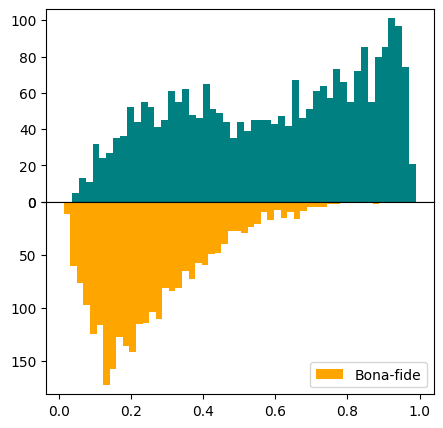

In [71]:
pos_scores = test_pred[test_labels == 1]
neg_scores = test_pred[test_labels == 0]
scores = [pos_scores, neg_scores]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,5))

labels = ['Spoof', 'Bona-fide']

bins = 50

for ax, score, color, invert, label in zip(axes.ravel(), scores, ['teal', 'orange'],  [False,True], labels):
    ax.hist(score, bins=bins, color=color, label=label)
    
    if invert:
        ax.invert_yaxis()

plt.legend(loc='lower right')
        
plt.subplots_adjust(hspace=0)

We can see that our model performs good on Bona-fide and a lot more poorly on Spoof. Probably we can add some spoof back and re-train it. Choosing better treshold depends on our goal - what metric we want to maximize (whether it's accuracy, precision, recall, f1, eer...).


In [75]:
print(f'EER is {calculate_eer(test_labels, test_pred)}')

EER is (0.2394034536888002, array(0.34841469))


EER (equal error rate) is the location on a ROC curve where the false positive rate and false negative rate are equal.

**4.4** <br>
Initially I overfitted on the training data but then I added weight decay and changed SGD to AdamW and got pretty decent results on 3 epochs. (I also switched to smaller architecture from b1 to b0).

**4.5**

Link to the project: https://wandb.ai/darkdestiny/voice-anti-spoofing/runs/o1f8zfu2?workspace=user-benchm <br>
Link to the weights: https://drive.google.com/file/d/11r2lGWlurRT_0c82uIApFEAn84v66x4z/view?usp=sharing

**Bonus task. (50 points)** 

So far, we didn't care about speaker_id and verification. Take verification model from whatever you want and create counter measure subnetwork, as described in this [article](https://sasv-challenge.github.io/pdfs/2022_descriptions/IDVoice.pdf). Train the model, as described there. ASVspoof also provides Enrollment(anchor) recordings. Try to make blending, to obtain better metrics for counter measures.

These links might be helpful:
- https://github.com/archinetai/surgeon-pytorch
- https://www.kaggle.com/code/peter0749/additive-margin-softmax-loss-with-visualization

## Problem 3. (30 pts)

### Task 1 (10 pts)

For FCNN (Fully connected Neural Networks)
\begin{equation}
f(x)=f_k\left(f_{k-1}\left(\ldots\left(f_0(x)\right)\right),\right.
\end{equation}
assume the nonlinearity function $\sigma$ is ReLU and loss function $L$ is squared error loss function.
Prove that the deep learning model is not unique for any datasets, i.e. the optimization problem 
\begin{equation}
\min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right), \text{where} \ \ \hat{y}_i=f\left(x_i, \theta\right),
\end{equation} 
dose not have an unique global minimizer $\theta$.

### Task 2 (5 pts)

The *softmax* activation function is 
\begin{equation}
\mathrm{Softmax}(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \text { for } \  i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K.
\end{equation}
Suppose $\mathbf{z} \in \mathbb{R}^K$, and $\mathbf{a} \in \mathbb{R}^K$,
Prove that for the optimization problem
\begin{equation}
\begin{aligned}
& \min_{\mathbf{a}} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
& \text { s.t. } \sum_k^K \mathbf{a}_{k}=1,
\end{aligned}
\end{equation}
the minimizer is 
\begin{equation}
\mathbf{a}^*=\mathrm{Softmax}(\mathbf{z}).
\end{equation}

*Hint*: KKT optimality conditions and convexiy of the problem can help you to show the required equality

### Task 3 (15 pts)

For function $f(x)=x^2, x \in \left[0, 1\right]$, 

1) prove that the neural network $\hat f(x)$ based on the following structure has the approximation error 
\begin{equation}
|f(x)-\hat f(x)|\leq \frac{1}{2^{n-1}}
\end{equation}
where $n$ is the number of layers in the neural network.

![](neural_parabola.png)

*Hint*: For each $ x \in \left[0, 1\right]$, $x$ can be denoted by its binary expansion $x=\sum_{i=0}^{∞} x_i/2^i$, where $x_i \in \{ 0, 1\}$. The above structure can be used to find $x_0,\dots, x_n$. Then we can write $\hat f(x)=f\left(\sum_{i=0}^{∞} x_i/2^i\right).$

After the proof, if we want to achieve $\epsilon$ appoximation error based on the above neural network, the number of layers $n$ has to satisfy the condition $\frac{1}{2^{n-1}}\leq \epsilon$, i.e. $n\geq \log_2 \frac{1}{\epsilon}$.

2) Implement this neural network in any framework you like with different $n$ (for example $n = 3, 5, 10, 15$), and then plot the curve for absolute errors for different $n$. Compare the obtained plots with theoretical bound.


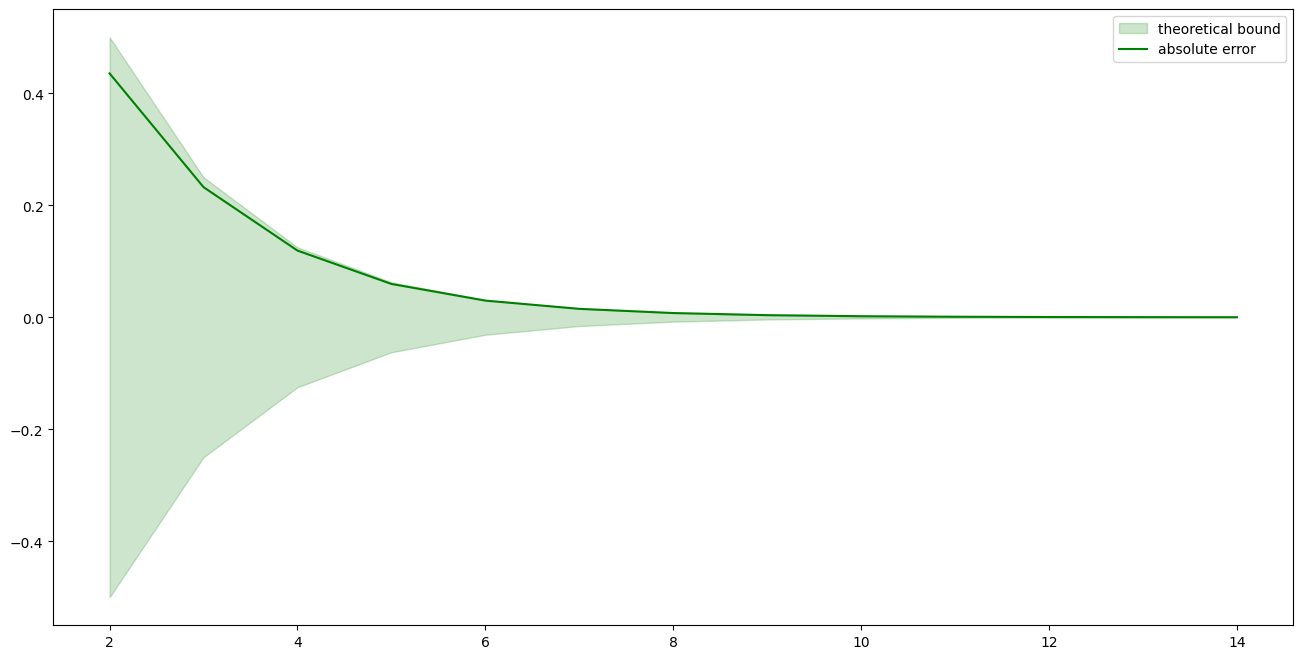

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def br_net(x, n_layers=1): #binary representation net
    terms = []
    for i in range(n_layers + 1):
        res = int(x >= 1 / 2**i)
        terms += [res]
        x -= res / 2**i
    return sum([terms[i]/2**i for i in range(len(terms))]) ** 2



layers = list(range(2, 15))
plt.figure(figsize=(16, 8))
plus, minus = [], []
error = []

for n_layers in layers: 
    x = np.linspace(0, 1, 1000)
    result = np.array([br_net(i, n_layers=n_layers) for i in x])
    error += [np.max(np.abs((x ** 2 - result)))]
    plus += [1 / 2 ** (n_layers - 1)]
    minus += [- 1 / 2 ** (n_layers - 1)]

plt.fill_between(layers, minus, plus, alpha=0.2, label=f'theoretical bound', color='g')
plt.plot(layers, error, label='absolute error', color='green')
plt.legend()

plt.show()




### Task 1
Assume we are trying to approximate $y_i = \text{ReLU} (x_i), \quad i \in \overline{1, N}, \quad x_i \in \mathbb{R}$, with 2-layer FCNN.
$$ f(x) = A_2\text{ReLU}(A_1x + b_1) + b_2$$
Since $\text{ReLU} (ax) = a \text{ReLU} (x)$ if $a > 0$ and $\text{ReLU}(\text{ReLU}(x)) = \text{ReLU}(x)$, we get that $f_1$ and $f_2$ defined bellow:
$$ \theta_1 = \{A_1 = A_2 = 1, \quad b_1 = b_2 = 0 \} \rightarrow f_1(x) = \text{ReLU} (x)$$
$$ \theta_2 = \{A_1 = 2, A_2 = 0.5, \quad b_1 = b_2 = 0\} \rightarrow f_2(x) = \text{ReLU} (x)$$
Both approximate $y_i$ with $0$ error:
$$ \forall k \in \overline{1,2} \rightarrow\frac{1}{N} \sum_{i=1}^N L\left(y_i, f_k(x_i)\right) = 0$$
Since 
$$ \min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right) \geq 0 $$
We get that both $\theta_1$ and $\theta_2$ deliver the minimum. <br>
We can take any appropriate loss function (MSE for example).


### Task 2

\begin{equation}
\begin{aligned}
& \min_{\mathbf{a} \in \mathbb{R}^K} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
& \text { s.t. } \sum_k^K \mathbf{a}_{k}=1,
\end{aligned}
\end{equation}

Using KKT:
$$\mathcal{L} = -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle + \lambda (1 - \langle 1, \mathbf{a} \rangle)$$
$$\begin{cases}
\frac{\partial \mathcal{L}}{\partial a} =  -z + \log a + 1 - \lambda = 0\\
\sum_k^K \mathbf{a}_{k}=1
\end{cases}$$
From the first equation we get:
$$a^* = \exp (z + \lambda - 1)$$
Substituting into the second one:
$$\sum_k \exp (z_k + \lambda - 1) = 1 \Rightarrow \exp(\lambda - 1) = \frac{1}{\sum_k \exp(z_k))}$$
$$ a^* = \exp (z + \lambda - 1) = \frac{\exp(z)}{\sum_k \exp(z_k))} = \mathrm{Softmax}(\mathbf{z})$$

### Task 3
$$|f(x) - \hat{f}(x)| = \left|f\left(x\right) - f\left(\sum_{i=1}^n\frac{x_i}{2^i}\right)\right| = \left|x^2 - \left(\sum_{i=1}^n\frac{x_i}{2^i}\right)^2\right| = \left|x - \sum_{i=1}^n\frac{x_i}{2^i}\right|\left|x + \sum_{i=1}^n\frac{x_i}{2^i}\right|
$$

$$\left|x + \sum_{i=1}^n\frac{x_i}{2^i}\right| \leq \left| x \right| + \left|\sum_{i=1}^n\frac{x_i}{2^i}\right| \leq 2 |x| \leq 2$$

$$
|f(x) - \hat{f}(x)| \leq 2\left|x - \sum_{i=1}^n\frac{x_i}{2^i}\right| = 2\left|\sum_{i=n+1}^\infty\frac{x_i}{2^i}\right|
$$

$$
\sum_{i=n+1}^\infty\frac{x_i}{2^i} \leq \sum_{i=n+1}^\infty\frac{1}{2^i} =\frac{1}{2^{n}}
$$

Grouping all together, we get

$$
|f(x) - \hat{f}(x)| \leq 2\frac{1}{2^{n}} = \frac{1}{2^{n - 1}}
$$